In [1]:
# Work with paths
import sys
sys.path.append('..')

# import implemented modules
import src.config as cfg
from src.data import make_dataset
import src.utils as utils
from src.features import features

# import other modules
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier, metrics, Pool

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import sklearn

# Generate Dataset

In [3]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/train.csv                      \
    --output_data_filepath=../data/processed/train_data.pkl     \
    --output_target_filepath=../data/processed/target_data.pkl

2022-10-16 14:42:27,802 - __main__ - INFO - making final data set from raw data
2022-10-16 14:42:27,829 - __main__ - INFO - Target saved to ../data/processed/target_data.pkl
2022-10-16 14:42:27,829 - __main__ - INFO - Dataset saved to ../data/processed/train_data.pkl


In [4]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/test.csv                       \
    --input_target_filepath=../data/raw/sample_solution.csv     \
    --output_data_filepath=../data/processed/val_data.pkl       \
    --output_target_filepath=../data/processed/val_target.pkl

2022-10-16 14:42:28,519 - __main__ - INFO - making final data set from raw data
2022-10-16 14:42:28,543 - __main__ - INFO - Target saved to ../data/processed/val_target.pkl
2022-10-16 14:42:28,543 - __main__ - INFO - Dataset saved to ../data/processed/val_data.pkl


Load dataset

In [30]:
train_data  = pd.read_pickle(str(os.getcwd() + "/../data/processed/train_data.pkl"))
target_data = pd.read_pickle(str(os.getcwd() + "/../data/processed/target_data.pkl"))

val_data   = pd.read_pickle(str(os.getcwd() + "/../data/processed/val_data.pkl"))
val_target = pd.read_pickle(str(os.getcwd() + "/../data/processed/val_target.pkl"))

Save fited transformation pipeline

In [31]:
full_data = pd.concat([train_data, val_data])

Transformer = utils.preprocess_pipe.fit(full_data)
utils.save_encoder(Transformer, str(os.getcwd() + "/../data/Transformer.pkl"))
Transformer = utils.load_encoder(str(os.getcwd() + "/../data/Transformer.pkl"))

Visualize data

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

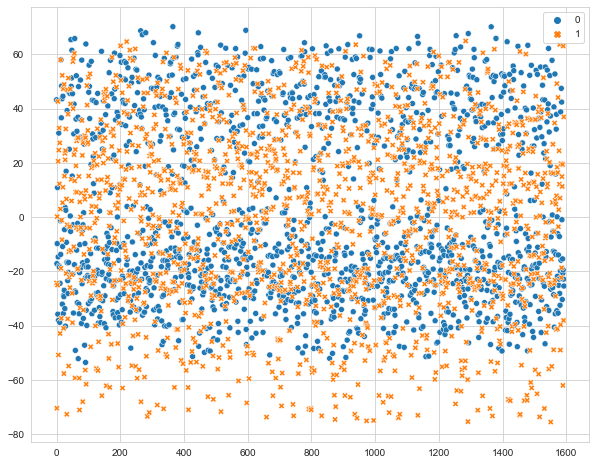

In [32]:
full_data_copy = Transformer.transform(full_data).copy()

tsne = TSNE(n_components=2, random_state=cfg.RANDOM_STATE, perplexity=15, n_iter=1000, verbose=0)
tsne_representation = tsne.fit_transform(full_data_copy)

plt.figure(figsize=(10,8))
sns.scatterplot(data=pd.DataFrame(tsne_representation))

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_86723/3059440385.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0, 'Z Label')

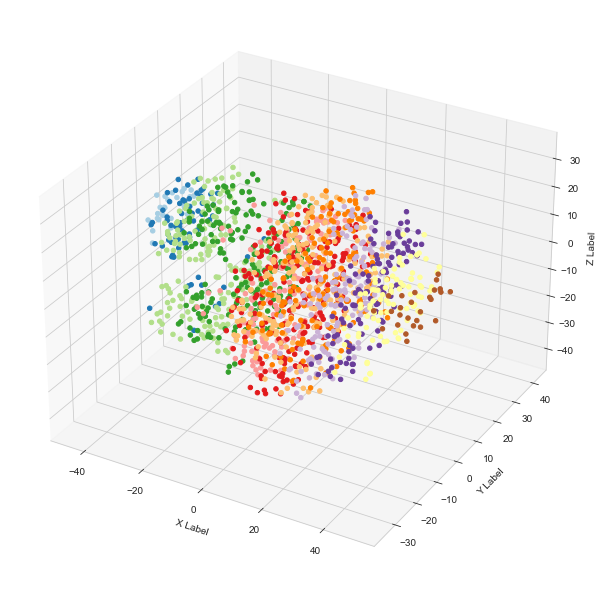

In [33]:
tsne = TSNE(n_components=3, random_state=cfg.RANDOM_STATE, perplexity=30, n_iter=1000)
tsne_representation = tsne.fit_transform(full_data_copy)

import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : True})

fig = plt.figure(figsize=(10,8))

ax = Axes3D(fig)
x = tsne_representation[:, 0]
y = tsne_representation[:, 1]
z = tsne_representation[:, 2]

g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

If we want to predict illness, we are interested in not getting FalseNegative that is why function is Recall

$$\text{Recall}=\frac{TP}{TP+FN}$$

Generate new features

In [34]:
train_data = features.make_condition_feature(train_data, features.is_zavoronok,   "is_zavoronok")
train_data = features.make_condition_feature(train_data, features.early_drinking, "early_drinking")

Generate tran and test selections

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    Transformer.transform(train_data),
                                                    target_data,
                                                    train_size=0.8,
                                                    random_state=cfg.RANDOM_STATE,
                                                    stratify=target_data.iloc[:,[1, 2, 3, 4]].sum(axis=1)
                                                    )

Catboost

In [79]:
train_pool = Pool(X_train, Y_train)
test_pool  = Pool(X_test, Y_test)

model = CatBoostClassifier(
    iterations=1000, 
    loss_function='MultiLogloss', 
    eval_metric='MultiLogloss',
    learning_rate=0.01,
    bootstrap_type='Bayesian', 
    boost_from_average=False,
    leaf_estimation_iterations=10, 
    leaf_estimation_method='Gradient', 
    custom_metric=['Recall', 'Precision', 'F1'],
    random_seed=cfg.RANDOM_STATE,
    task_type='CPU',
    devices='0:1',
)

model.fit(train_pool, 
        eval_set=test_pool, 
        metric_period=10, 
        plot=True, 
        verbose=True, 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6871650	test: 0.6873138	best: 0.6873138 (0)	total: 6.13ms	remaining: 6.12s
10:	learn: 0.6328486	test: 0.6347692	best: 0.6347692 (10)	total: 67.4ms	remaining: 6.06s
20:	learn: 0.5874997	test: 0.5906362	best: 0.5906362 (20)	total: 112ms	remaining: 5.21s
30:	learn: 0.5483113	test: 0.5528230	best: 0.5528230 (30)	total: 155ms	remaining: 4.84s
40:	learn: 0.5160768	test: 0.5218888	best: 0.5218888 (40)	total: 198ms	remaining: 4.62s
50:	learn: 0.4889029	test: 0.4958552	best: 0.4958552 (50)	total: 242ms	remaining: 4.5s
60:	learn: 0.4658248	test: 0.4738023	best: 0.4738023 (60)	total: 284ms	remaining: 4.37s
70:	learn: 0.4459481	test: 0.4550275	best: 0.4550275 (70)	total: 327ms	remaining: 4.27s
80:	learn: 0.4291530	test: 0.4391585	best: 0.4391585 (80)	total: 367ms	remaining: 4.16s
90:	learn: 0.4153198	test: 0.4262856	best: 0.4262856 (90)	total: 407ms	remaining: 4.07s
100:	learn: 0.4033556	test: 0.4152371	best: 0.4152371 (100)	total: 449ms	remaining: 4s
110:	learn: 0.3927692	test: 0.4055

In [83]:
model.best_score_.get('validation')

model.best_score_.get('learn')

{'Precision:class=3': 1.0,
 'Recall:class=3': 0.11538461538461539,
 'F1:class=2': 0.2857142857142857,
 'F1:class=0': 0.8647140864714087,
 'Recall:class=0': 0.8722222222222222,
 'Precision:class=1': 1.0,
 'Recall:class=2': 0.16666666666666666,
 'Precision:class=4': 1.0,
 'Precision:class=2': 1.0,
 'F1:class=3': 0.20689655172413793,
 'Precision:class=0': 0.8683473389355743,
 'Recall:class=1': 0.0,
 'Recall:class=4': 0.04477611940298507,
 'F1:class=4': 0.08571428571428572,
 'F1:class=1': 0.0,
 'MultiLogloss': 0.21564018081119896}

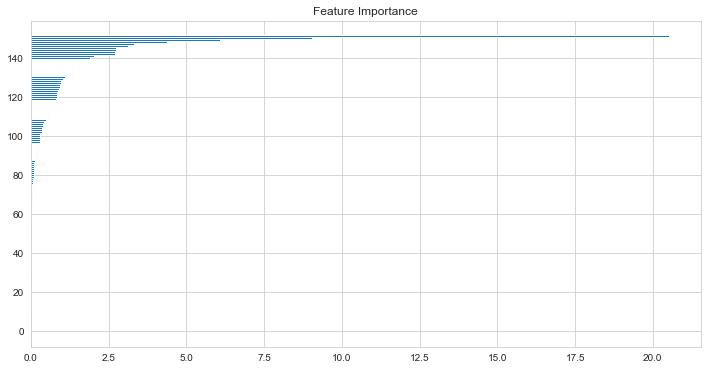

In [37]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.show()

inference

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


Y_real = np.array(val_target.copy().drop(columns=[cfg.ID_COL]))
Y_pred = np.array(model.predict(Transformer.transform(val_data)), dtype=np.int8)

accuracy_score(Y_pred, Y_real)
recall_score(Y_real, Y_pred, average=None, zero_division=0)

array([0., 0., 0., 0., 0.])

Tuning

In [14]:
df = pd.concat([train_data, target_data], axis=1).copy()


from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

kf = KFold(n_splits=3, shuffle=True)

DEFAULT_PARAMETERS = {'n_estimators' : 4500, 'learning_rate' : 0.1}
DEFAULT_MODEL_METRICS = {}


def score_catboost_model(df, catboost_parameters, update_defaults=False):
    r2_values = []
    rmse_values = []
    catboost_parameters.update(DEFAULT_PARAMETERS)
    for train_index, test_index in kf.split(df):
        train_pool = Pool(pd.DataFrame(Transformer.transform(df)[train_index, :-5]).T,
                          pd.DataFrame(Transformer.transform(df)[train_index, -5:]).T
        )

        test_pool = Pool(pd.DataFrame(Transformer.transform(df)[test_index, :-5]).T,
                         pd.DataFrame(Transformer.transform(df)[test_index, -5:]).T  
        )

        model = CatBoostClassifier(catboost_parameters)
        model.fit(train_pool, verbose=False)
        
        r2_values.append(r2_score(df.iloc[test_index].price_usd.values, model.predict(test_pool)))
        rmse_values.append(mean_squared_error(df.iloc[test_index].price_usd.values,
                                              model.predict(test_pool),
                                              squared=False)) 
    if update_defaults:
        DEFAULT_MODEL_METRICS['R2'] = np.mean(r2_values)
        DEFAULT_MODEL_METRICS['RMSE'] = np.mean(rmse_values)
        print('R2 score: {:.4f}({:.4f})'.format(np.mean(r2_values), np.std(r2_values)))
        print('RMSE score: {:.0f}({:.0f})'.format(np.mean(rmse_values), np.std(rmse_values)))  

    else:
        DEFAULT_MODEL_R2 = DEFAULT_MODEL_METRICS['R2']
        DEFAULT_MODEL_RMSE = DEFAULT_MODEL_METRICS['RMSE']
        r2_change = 100 * (np.mean(r2_values) - DEFAULT_MODEL_R2) / DEFAULT_MODEL_R2
        rmse_change = 100 * (np.mean(rmse_values) - DEFAULT_MODEL_RMSE) / DEFAULT_MODEL_RMSE
        print('R2 score: {:.4f}({:.4f}) {:+.1f}% compared to default parameters'.format(
            np.mean(r2_values), np.std(r2_values), r2_change))
        print('RMSE score: {:.0f}({:.0f}) {:+.1f}% compared to default parameters'.format(
            np.mean(rmse_values), np.std(rmse_values), rmse_change))  
        
    return model.get_all_params()


In [ ]:
model_params = score_catboost_model(train_data, {'model_size_reg': 0})